# U-net segmentation with GMM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


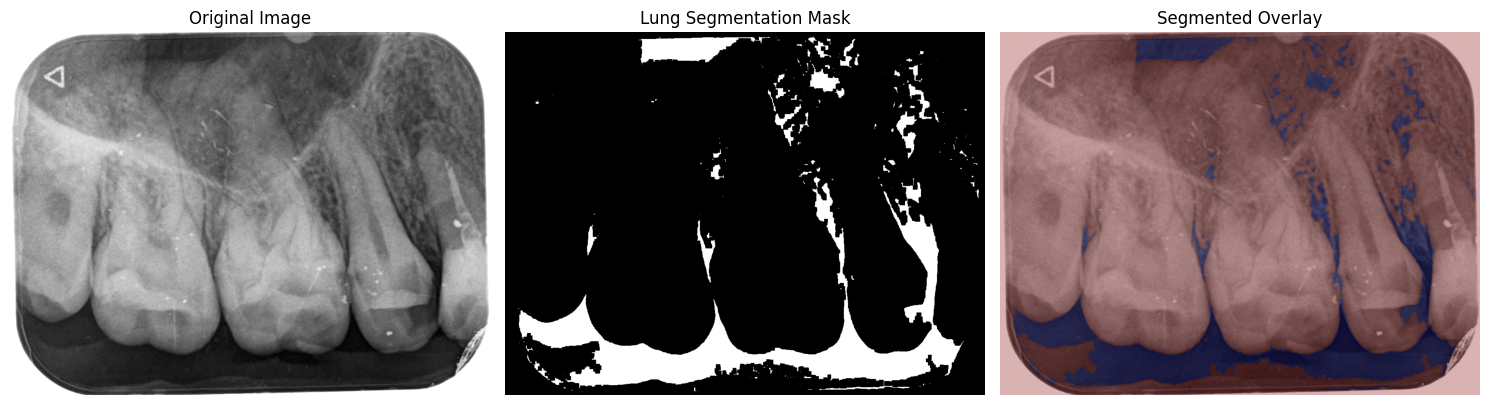

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the X-ray image
image_path = "/content/drive/MyDrive/Caries/12.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply contrast enhancement (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply(image)

# Apply thresholding to segment the lungs
_, thresholded = cv2.threshold(enhanced_image, 50, 255, cv2.THRESH_BINARY_INV)

# Use morphological operations to refine the mask
kernel = np.ones((5, 5), np.uint8)
thresholded = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel, iterations=2)

# Find contours and create a mask
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(image)
cv2.drawContours(mask, contours, -1, 255, thickness=-1)

# Overlay mask on the original image
overlay = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
output_image = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), 0.7, overlay, 0.3, 0)

# Display results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image, cmap="gray")
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Lung Segmentation Mask")
ax[1].axis("off")

ax[2].imshow(output_image)
ax[2].set_title("Segmented Overlay")
ax[2].axis("off")

plt.tight_layout()
plt.show()


Showing sample from dataset (original image & morphological mask).


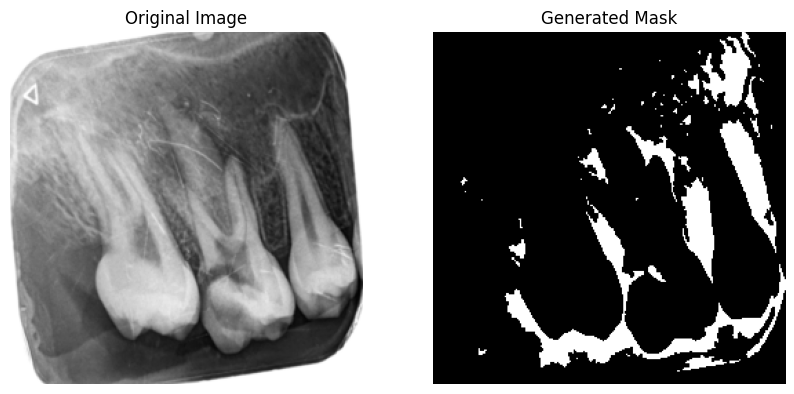


Training the model...

Epoch 1/5, Loss: 0.3977
Epoch 2/5, Loss: 0.2939
Epoch 3/5, Loss: 0.2711
Epoch 4/5, Loss: 0.2487
Epoch 5/5, Loss: 0.2393

Showing prediction on sample idx=0...


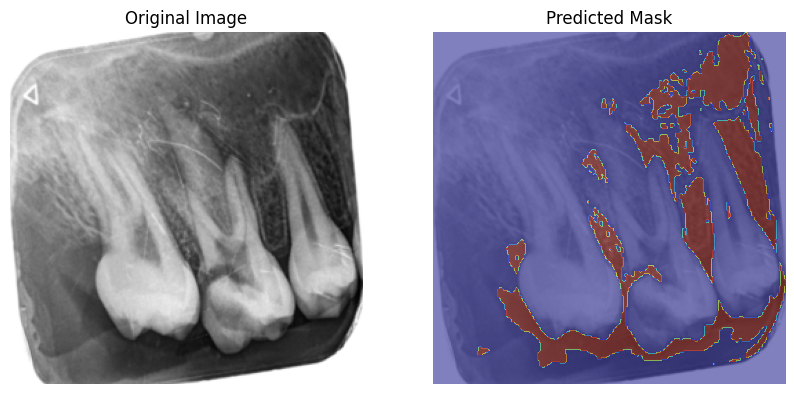

In [24]:
# -----------------------------
#  ALL-IN-ONE SCRIPT
# -----------------------------
# 1) Create a Dataset that loads images (from a folder)
#    and generates morphological masks on the fly.
# 2) Define a U-Net model.
# 3) Train the U-Net on these (image,mask) pairs.
# 4) Show the predicted mask vs. the original.

%matplotlib inline
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T

# -----------------------------
# A) Morphological Mask Function
# -----------------------------
def generate_morphological_mask(grayscale_image, threshold_val=50):
    """
    Given a grayscale image (numpy array), apply:
      1) Contrast enhancement (CLAHE)
      2) Thresholding
      3) Morphological closing
      4) Contour-filling
    Returns a binary mask (numpy) of the same size (0 or 255).
    """
    # Apply contrast enhancement (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(grayscale_image)

    # Threshold (inverse binary -> foreground is white=255)
    _, thresh = cv2.threshold(enhanced_img, threshold_val, 255, cv2.THRESH_BINARY_INV)

    # Morphological closing
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find external contours & fill them
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(grayscale_image, dtype=np.uint8)
    cv2.drawContours(mask, contours, -1, 255, thickness=-1)

    return mask  # values in {0,255}

# -----------------------------
# B) Dataset Class
# -----------------------------
class CariesOnTheFlyDataset(Dataset):
    """
    - Reads images from `image_folder`.
    - For each image:
       1) Load it as grayscale for morphological mask generation.
       2) Generate a morphological mask on-the-fly (0 or 255).
       3) Also load the image as RGB for training input.
       4) Return (image_tensor, mask_tensor).
    """
    def __init__(self, image_folder, transform_img=None, transform_mask=None, threshold_val=50):
        super().__init__()
        self.image_paths = sorted(glob.glob(os.path.join(image_folder, "*.*")))
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.threshold_val = threshold_val

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # 1) Read grayscale for morphological mask
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask_255 = generate_morphological_mask(gray_img, threshold_val=self.threshold_val)

        # 2) Convert mask_255 into a PIL Image
        mask_pil = Image.fromarray(mask_255)  # 8-bit grayscale in {0,255}

        # 3) Read image as RGB via PIL
        img_pil = Image.open(img_path).convert("RGB")

        # 4) Apply transforms to the original image
        if self.transform_img:
            img_tensor = self.transform_img(img_pil)  # e.g. (3,H,W)
        else:
            img_tensor = T.ToTensor()(img_pil)

        # 5) Apply transforms to the mask
        if self.transform_mask:
            mask_tensor = self.transform_mask(mask_pil)  # e.g. (1,H,W)
        else:
            mask_tensor = T.ToTensor()(mask_pil)

        # Convert {0,255} -> {0,1}
        mask_tensor = (mask_tensor > 0.5).float()

        return img_tensor, mask_tensor


# -----------------------------
# C) U-Net Definition
# -----------------------------
class DoubleConv(nn.Module):
    """(Conv => BN => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    """Downscale with maxpool => double conv"""
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscale => concatenate => double conv"""
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Padding if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2,
                        diffY//2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    """U-Net for binary segmentation: 1 output channel => (0 or 1)"""
    def __init__(self, n_channels=3, n_classes=1, base_ch=64, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, base_ch)
        self.down1 = Down(base_ch, base_ch*2)
        self.down2 = Down(base_ch*2, base_ch*4)
        self.down3 = Down(base_ch*4, base_ch*8)
        self.down4 = Down(base_ch*8, base_ch*8)

        self.up1 = Up(base_ch*16, base_ch*4, bilinear)
        self.up2 = Up(base_ch*8, base_ch*2, bilinear)
        self.up3 = Up(base_ch*4, base_ch, bilinear)
        self.up4 = Up(base_ch*2, base_ch, bilinear)

        self.outc = nn.Conv2d(base_ch, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# -----------------------------
# D) Training Function
# -----------------------------
def train_unet(model, dataloader, epochs=5, lr=1e-4, device='cuda'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, masks in dataloader:
            images = images.to(device, dtype=torch.float)
            masks  = masks.to(device, dtype=torch.float)

            optimizer.zero_grad()
            logits = model(images)   # shape (B,1,H,W)
            loss   = criterion(logits, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

    return model


# -----------------------------
# E) Visualization Functions
# -----------------------------
def show_sample(dataset, idx=0):
    """Show the original image & morphological mask from the dataset."""
    image_tensor, mask_tensor = dataset[idx]
    image_np = image_tensor.permute(1,2,0).numpy()
    mask_np  = mask_tensor[0].numpy()

    fig, axes = plt.subplots(1,2, figsize=(10,5))
    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask_np, cmap="gray")
    axes[1].set_title("Generated Mask")
    axes[1].axis("off")

    plt.show()

def show_prediction(model, dataset, idx=0, device='cuda', threshold=0.5):
    """Show the model prediction vs. the original image."""
    model.eval()
    with torch.no_grad():
        img, _ = dataset[idx]
        img_4d = img.unsqueeze(0).to(device, dtype=torch.float)
        logits = model(img_4d)
        prob   = torch.sigmoid(logits)  # (1,1,H,W)
        pred   = (prob > threshold).float()

    # Convert to numpy
    image_np = img.permute(1,2,0).numpy()  # shape(H,W,3)
    mask_np  = pred[0,0].cpu().numpy()     # shape(H,W)

    fig, axes = plt.subplots(1,2, figsize=(10,5))
    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Show predicted mask
    axes[1].imshow(image_np, alpha=0.7)
    axes[1].imshow(mask_np, cmap="jet", alpha=0.5)
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")

    plt.show()


# -----------------------------
# F) Main Pipeline
# -----------------------------
def main():
    # Path to your images folder
    image_folder = "/content/drive/MyDrive/Caries"  # <= change as needed

    # Check if folder is valid
    if not os.path.isdir(image_folder):
        raise ValueError(f"Folder not found: {image_folder}")

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Create the dataset with on-the-fly mask generation
    transform_img = T.Compose([
        T.Resize((256,256)),
        T.ToTensor()
    ])
    transform_mask = T.Compose([
        T.Resize((256,256)),
        T.ToTensor()
    ])

    dataset = CariesOnTheFlyDataset(
        image_folder=image_folder,
        transform_img=transform_img,
        transform_mask=transform_mask,
        threshold_val=50  # you can tweak the threshold
    )

    # Quick check: Show original + morphological mask for idx=0
    if len(dataset) == 0:
        print("No images found in the provided folder.")
        return

    print("Showing sample from dataset (original image & morphological mask).")
    show_sample(dataset, idx=0)

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

    # Initialize the U-Net
    model = UNet(n_channels=3, n_classes=1, base_ch=64, bilinear=True)
    print("\nTraining the model...\n")
    trained_model = train_unet(model, dataloader, epochs=5, lr=1e-4, device=device)

    # Show a final prediction
    print("\nShowing prediction on sample idx=0...")
    show_prediction(trained_model, dataset, idx=0, device=device, threshold=0.5)


# -----------------------------
# G) Run everything
# -----------------------------
if __name__ == "__main__":
    main()


Showing an example GMM mask...


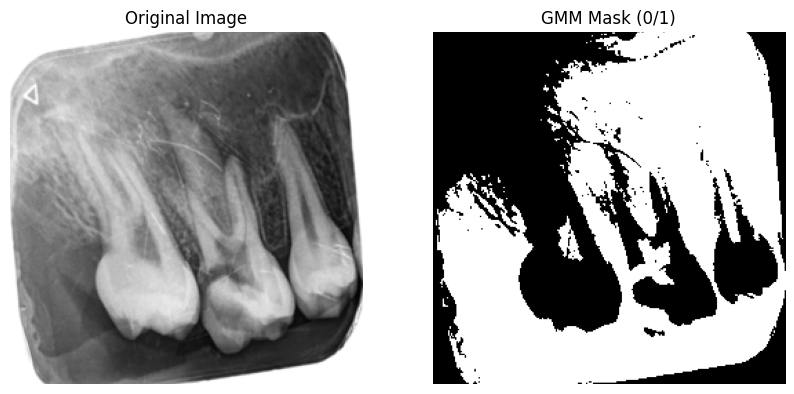


Training U-Net with GMM-based masks...

Epoch 1/5, Loss: 0.4154
Epoch 2/5, Loss: 0.3310
Epoch 3/5, Loss: 0.3243
Epoch 4/5, Loss: 0.3262
Epoch 5/5, Loss: 0.3220

Showing final prediction on sample idx=0...


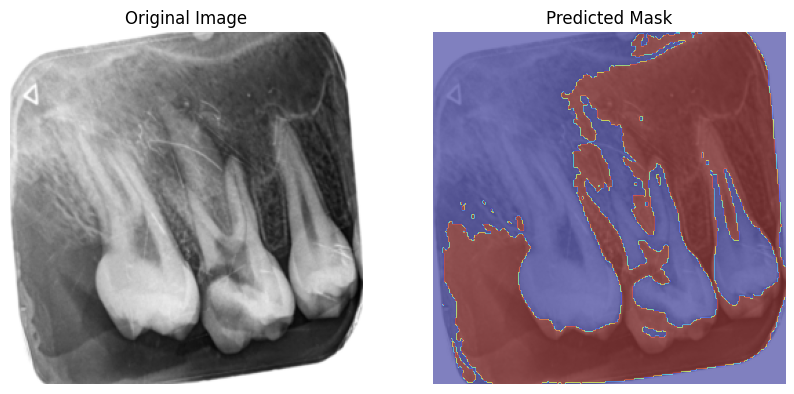

In [25]:
%matplotlib inline

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# For Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

################################################################################
# 1) GMM-Based Mask Generation
################################################################################

def generate_gmm_mask(grayscale_image, n_components=2):
    """
    Given a single-channel (grayscale) image (NumPy array),
    fit a GMM with 'n_components' Gaussians and produce a binary mask.

    Steps:
    1) Flatten the image into a 1D array of intensities.
    2) Fit a GMM on these intensities.
    3) Predict the cluster index for each pixel.
    4) Identify which cluster is foreground (usually the darker cluster, but you can adjust logic).
    5) Reshape predictions back to the original image shape.
    6) Return a mask in {0, 255}.
    """
    # Flatten grayscale to shape (num_pixels, 1)
    flat = grayscale_image.reshape(-1, 1).astype(np.float32)

    # Fit GMM
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(flat)

    # Get predicted cluster for each pixel
    labels = gmm.predict(flat)  # shape = (num_pixels, )

    # We can assume the cluster with the smaller mean intensity is "foreground"
    # (Adjust logic if your images differ.)
    cluster_means = gmm.means_.flatten()  # shape = (n_components,)
    # Sort clusters by mean intensity
    sorted_indices = np.argsort(cluster_means)
    # The cluster with the smallest mean is at index sorted_indices[0]
    # We'll call that cluster "foreground".
    foreground_cluster = sorted_indices[0]

    # Convert predictions to a binary mask in {0,255}
    #  => 255 where cluster == foreground_cluster, else 0
    mask_255 = np.where(labels == foreground_cluster, 255, 0).astype(np.uint8)
    # Reshape to original HxW
    mask_255 = mask_255.reshape(grayscale_image.shape)

    return mask_255


################################################################################
# 2) On-The-Fly Dataset Using GMM
################################################################################

class CariesGMMOnTheFlyDataset(Dataset):
    """
    - Reads images from `image_folder`.
    - For each image:
        1) Load as grayscale -> apply GMM to get a binary mask (0 or 255).
        2) Load as RGB -> for training input.
        3) Return (image_tensor, mask_tensor).
    """
    def __init__(self, image_folder, transform_img=None, transform_mask=None, n_components=2):
        super().__init__()
        self.image_paths = sorted(glob.glob(os.path.join(image_folder, "*.*")))
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.n_components = n_components

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # 1) Read the image as grayscale for GMM
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask_255 = generate_gmm_mask(gray_img, n_components=self.n_components)

        # 2) Convert mask to PIL
        mask_pil = Image.fromarray(mask_255)

        # 3) Read image as RGB via PIL
        img_pil = Image.open(img_path).convert("RGB")

        # 4) Transforms for image
        if self.transform_img:
            img_tensor = self.transform_img(img_pil)  # e.g. (3,H,W)
        else:
            img_tensor = T.ToTensor()(img_pil)

        # 5) Transforms for mask
        if self.transform_mask:
            mask_tensor = self.transform_mask(mask_pil)  # e.g. (1,H,W)
        else:
            mask_tensor = T.ToTensor()(mask_pil)

        # Convert {0,255} -> {0,1}
        mask_tensor = (mask_tensor > 0.5).float()

        return img_tensor, mask_tensor


################################################################################
# 3) U-Net Definition
################################################################################

class DoubleConv(nn.Module):
    """(Conv => BN => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    """Downscale with maxpool => double conv"""
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscale => concatenate => double conv"""
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Padding if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2,
                        diffY//2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    """U-Net for binary segmentation: 1 output channel => (0 or 1)"""
    def __init__(self, n_channels=3, n_classes=1, base_ch=64, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, base_ch)
        self.down1 = Down(base_ch, base_ch*2)
        self.down2 = Down(base_ch*2, base_ch*4)
        self.down3 = Down(base_ch*4, base_ch*8)
        self.down4 = Down(base_ch*8, base_ch*8)

        self.up1 = Up(base_ch*16, base_ch*4, bilinear)
        self.up2 = Up(base_ch*8, base_ch*2, bilinear)
        self.up3 = Up(base_ch*4, base_ch, bilinear)
        self.up4 = Up(base_ch*2, base_ch, bilinear)

        self.outc = nn.Conv2d(base_ch, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


################################################################################
# 4) Training
################################################################################

def train_unet(model, dataloader, epochs=5, lr=1e-4, device='cuda'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, masks in dataloader:
            images = images.to(device, dtype=torch.float)
            masks  = masks.to(device, dtype=torch.float)

            optimizer.zero_grad()
            logits = model(images)  # shape (B,1,H,W)
            loss   = criterion(logits, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

    return model


################################################################################
# 5) Visualization
################################################################################

def show_gmm_mask(dataset, idx=0):
    """ Show the original image and the GMM-generated mask from the dataset. """
    img_tensor, mask_tensor = dataset[idx]  # (3,H,W), (1,H,W)
    img_np  = img_tensor.permute(1,2,0).numpy()
    mask_np = mask_tensor[0].numpy()

    fig, axes = plt.subplots(1,2, figsize=(10,5))
    axes[0].imshow(img_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask_np, cmap="gray")
    axes[1].set_title("GMM Mask (0/1)")
    axes[1].axis("off")

    plt.show()

def show_prediction(model, dataset, idx=0, device='cuda', threshold=0.5):
    """ Show the original image and the predicted mask from the model. """
    model.eval()
    with torch.no_grad():
        img_tensor, _ = dataset[idx]
        img_4d = img_tensor.unsqueeze(0).to(device, dtype=torch.float)
        logits = model(img_4d)
        prob   = torch.sigmoid(logits)  # shape (1,1,H,W)
        pred   = (prob > threshold).float()

    # Move to CPU
    img_np  = img_tensor.permute(1,2,0).numpy()
    pred_np = pred[0,0].cpu().numpy()

    fig, axes = plt.subplots(1,2, figsize=(10,5))
    axes[0].imshow(img_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(img_np, alpha=0.7)
    axes[1].imshow(pred_np, cmap='jet', alpha=0.5)
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")

    plt.show()


################################################################################
# 6) Main Demo
################################################################################

def main():
    # Path to your folder of images
    image_folder = "/content/drive/MyDrive/Caries"  # <-- Adjust as needed

    if not os.path.isdir(image_folder):
        print(f"Error: Folder not found: {image_folder}")
        return

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Create the GMM-based dataset
    transform_img = T.Compose([
        T.Resize((256,256)),
        T.ToTensor()
    ])
    transform_mask = T.Compose([
        T.Resize((256,256)),
        T.ToTensor()
    ])

    dataset = CariesGMMOnTheFlyDataset(
        image_folder=image_folder,
        transform_img=transform_img,
        transform_mask=transform_mask,
        n_components=2  # you can try 2 or 3, etc.
    )

    if len(dataset) == 0:
        print("No images found in the specified folder.")
        return

    # Show one sample's GMM mask
    print("Showing an example GMM mask...")
    show_gmm_mask(dataset, idx=0)

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

    # Initialize and train U-Net
    print("\nTraining U-Net with GMM-based masks...\n")
    model = UNet(n_channels=3, n_classes=1, base_ch=64, bilinear=True)
    epochs = 5
    trained_model = train_unet(model, dataloader, epochs=epochs, lr=1e-4, device=device)

    # Show prediction on the same sample (idx=0)
    print("\nShowing final prediction on sample idx=0...")
    show_prediction(trained_model, dataset, idx=0, device=device, threshold=0.5)


# -----------------------------
# Run everything
# -----------------------------
if __name__ == "__main__":
    main()
